## Modeling for predicting critical outcome at ED triage

Work Flow:
1. Task-specific filter
2. Variable selection
3. Modeling script
4. Performance output


### Load train and test

In [42]:
import os
import time
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from helpers import PlotROCCurve

#path = 'C:/Users/XFE/Documents/mimic4ed-benchmark/data_processed/'
path = '/home/jun/data/MIMIC/processed'
#path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark'
#output_path = '/Users/siqili/Desktop/National University of Singapore/Liu Nan - WP_MIMIC_Benchmark/Figure3/'
output_path='.'
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0

In [43]:
pd.set_option('display.max_columns', 100) 
pd.set_option('display.max_rows', 100) 

df_train.head()

,index,subject_id,hadm_id,stay_id,intime,outtime,anchor_age,gender,anchor_year,dod,admittime,dischtime,deathtime,ethnicity,edregtime,edouttime,insurance,in_year,age,outcome_inhospital_mortality,ed_death,before_ed_mortality,ed_los,intime_icu,time_to_icu_transfer,outcome_icu_transfer_12h,outcome_hospitalization,outcome_critical,n_ed_30d,n_ed_90d,n_ed_365d,next_ed_visit_time,next_ed_visit_time_diff,outcome_ed_revisit_3d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,ed_los_hours,time_to_icu_transfer_hours,next_ed_visit_time_diff_days,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,...,eci_CHF,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_PVD,eci_HTN1,eci_HTN2,eci_Paralysis,eci_NeuroOther,eci_Pulmonary,eci_DM1,eci_DM2,eci_Hypothyroid,eci_Renal,eci_Liver,eci_PUD,eci_HIV,eci_Lymphoma,eci_Tumor2,eci_Tumor1,eci_Rheumatic,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression,ed_temperature_last,ed_heartrate_last,ed_resprate_last,ed_o2sat_last,ed_sbp_last,ed_dbp_last,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS,score_SERP2d,score_SERP7d,score_SERP30d
0,215414,18566742,27103162.0,38538786,2135-07-16 16:08:00,2135-07-17 01:49:00,58,F,2132,NaN,2135-07-17 00:20:00,2135-07-18 18:20:00,NaN,HISPANIC/LATINO,2135-07-16 16:08:00,2135-07-17 01:49:00,Other,2135,61,False,False,False,0 days 09:41:00,NaN,NaN,False,True,False,0,0,0,2136-07-30 17:08:00,379 days 15:19:00,False,0,0,0,0,0,0,9.68,NaN,379.64,37.166667,93.0,16.0,100.0,160.0,66.0,4.167576,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.760621,78.220568,17.260731,98.141378,127.427849,73.556876,2.127651,5.0,2.0,97.333333,2,4,3,1,1,1,16,21,16
1,205452,16853729,NaN,30043998,2178-01-25 05:09:00,2178-01-25 07:05:00,91,F,2169,NaN,NaN,NaN,NaN,OTHER,NaN,NaN,NaN,2178,100,False,False,False,0 days 01:56:00,NaN,NaN,False,False,False,0,1,7,2178-03-11 09:43:00,45 days 02:38:00,False,0,0,5,0,0,0,1.93,NaN,45.11,36.666667,76.0,20.0,95.0,165.0,95.0,4.167576,...,0,0,0,0,0,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,36.777778,75.000000,18.000000,97.000000,133.000000,80.000000,2.127651,2.0,3.0,118.333333,7,9,8,1,0,1,28,33,29
2,200705,16026698,NaN,39475313,2128-10-19 20:01:00,2128-10-19 20:16:00,23,M,2128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2128,23,False,False,False,0 days 00:15:00,NaN,NaN,False,False,False,0,0,1,2129-01-05 21:12:00,78 days 00:56:00,False,0,0,0,0,0,0,0.25,NaN,78.04,37.222222,125.0,22.0,99.0,156.0,96.0,7.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36.833333,95.000000,18.000000,100.000000,143.000000,82.000000,7.000000,1.0,1.0,116.000000,0,12,4,4,4,4,18,20,17
3,87038,15398519,25237915.0,35495155,2147-06-15 09:50:00,2147-06-15 15:55:00,57,M,2136,NaN,2147-06-15 14:00:00,2147-06-16 16:45:00,NaN,BLACK/AFRICAN AMERICAN,2147-06-15 09:50:00,2147-06-15 15:55:00,Medicare,2147,68,False,False,False,0 days 06:05:00,NaN,NaN,False,True,False,0,2,5,2147-07-01 10:46:00,15 days 18:51:00,False,0,2,5,0,0,1,6.08,NaN,15.79,37.166667,110.0,22.0,92.0,122.0,89.0,7.000000,...,0,1,1,1,0,1,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,36.777778,106.000000,20.000000,92.000000,96.000000,75.000000,0.000000,7.0,10.0,100.000000,12,16,7,5,3,3,36,36,31
4,373626,16787687,23674090.0,31087259,2181-03-20 10:38:00,2181-03-21 12:55:00,87,F,2176,NaN,2181-03-20 22:01:00,2181-03-21 12:55:00,NaN,BLACK/AFRICAN AMERICAN,2181-03-20 10:38:00,2181-03-21 12:55:00,Medicare,2181,92,False,False,False,1 days 02:17:00,NaN,NaN,False,True,False,0,0,2,2181-04-06 09:43:00,15 days 20:48:00,False,0,0,2,0,0,0,26.28,NaN,15.87,37.111111,90.0,14.0,99.0,125.0,68.0,3.000000,...,1,0,0,0,0,1,0,0,1,1,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,36.666667,74.000000,18.000000,98.000000,100.000000,59.000000,0.000000,6.0,13.0,87.000000,11,9,6,0,0,0,32,36,31


### 1. task-specific filter

In [44]:
df_train = df_train[df_train['ed_death'] == False]
df_test = df_test[df_test['ed_death'] == False]

### 2. Variable Selection

In [45]:
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_temperature", "triage_heartrate", "triage_resprate", 
            "triage_o2sat", "triage_sbp", "triage_dbp", "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache",
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope", 
            "chiefcom_dizziness", 
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", 
            "cci_Pulmonary", "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", 
            "cci_DM2", "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", 
            "cci_Cancer2", "cci_HIV", 
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2", 
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss",
            "eci_Anemia", "eci_Alcohol", "eci_Drugs","eci_Psychoses", "eci_Depression"]

outcome = "outcome_critical"

In [46]:
X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()
X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

In [47]:
X_train.dtypes.to_frame().T

,age,gender,n_ed_30d,n_ed_90d,n_ed_365d,n_hosp_30d,n_hosp_90d,n_hosp_365d,n_icu_30d,n_icu_90d,n_icu_365d,triage_temperature,triage_heartrate,triage_resprate,triage_o2sat,triage_sbp,triage_dbp,triage_pain,triage_acuity,chiefcom_chest_pain,chiefcom_abdominal_pain,chiefcom_headache,chiefcom_shortness_of_breath,chiefcom_back_pain,chiefcom_cough,chiefcom_nausea_vomiting,chiefcom_fever_chills,chiefcom_syncope,chiefcom_dizziness,cci_MI,cci_CHF,cci_PVD,cci_Stroke,cci_Dementia,cci_Pulmonary,cci_Rheumatic,cci_PUD,cci_Liver1,cci_DM1,cci_DM2,cci_Paralysis,cci_Renal,cci_Cancer1,cci_Liver2,cci_Cancer2,cci_HIV,eci_Arrhythmia,eci_Valvular,eci_PHTN,eci_HTN1,eci_HTN2,eci_NeuroOther,eci_Hypothyroid,eci_Lymphoma,eci_Coagulopathy,eci_Obesity,eci_WeightLoss,eci_FluidsLytes,eci_BloodLoss,eci_Anemia,eci_Alcohol,eci_Drugs,eci_Psychoses,eci_Depression
0,int64,object,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64


In [48]:
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])

In [49]:
print('class ratio')
ratio = y_train.sum()/(~y_train).sum()
print('positive : negative =', ratio, ': 1')

### 3.  Modeling script

In [50]:
# Containers for all results
result_list = []

Logistic Regression:


/home/jun/virtualenvs/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 5.1768999099731445 seconds
AUC: 0.844728597513773
AUPRC: 0.31846220162093547
Sensitivity: 0.7859311740890689
Specificity: 0.7292919171676686
Score thresold: 0.058781732026283055
2.5 97.5


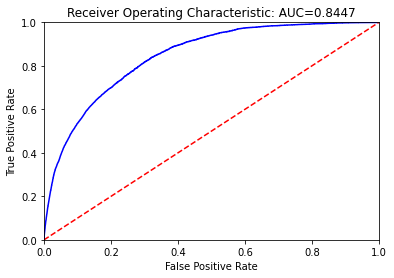

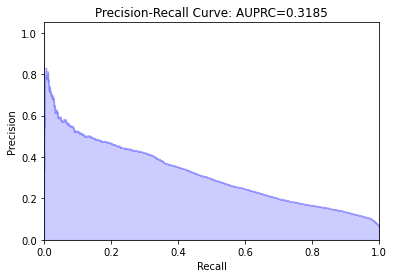

In [51]:
print("Logistic Regression:")
from sklearn.linear_model import LogisticRegression
logreg=LogisticRegression(random_state=random_seed)
start = time.time()
logreg.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = logreg.predict_proba(X_test)
result = PlotROCCurve(probs[:,1], y_test, ci=confidence_interval, random_state=random_seed)

results = ["LR"]
results.extend(result)
results.append(runtime)
result_list.append(results)



MLP:
Training time: 403.01605200767517 seconds
AUC: 0.8898771120014592
AUPRC: 0.41252190997567517
Sensitivity: 0.8144399460188934
Specificity: 0.8029869262334193
Score thresold: 0.07249249452199924
2.5 97.5


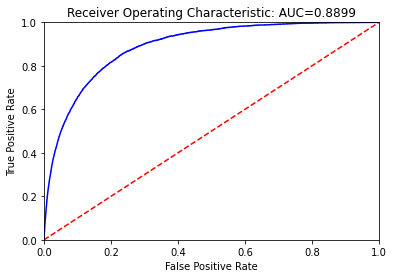

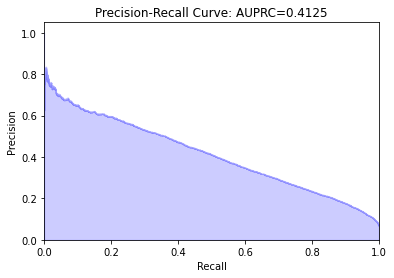

In [52]:
print("MLP:")
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=random_seed)
start = time.time()
mlp.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = mlp.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test,random_seed=random_seed)

results = ["MLP"]
results.extend(result)
results.append(runtime)
result_list.append(results)


RandomForest:
Training time: 53.16841530799866 seconds
AUC: 0.8858859566137609
AUPRC: 0.420576110069897
Sensitivity: 0.8034750337381916
Specificity: 0.8087365206603684
Score thresold: 0.08270503352856295
2.5 97.5


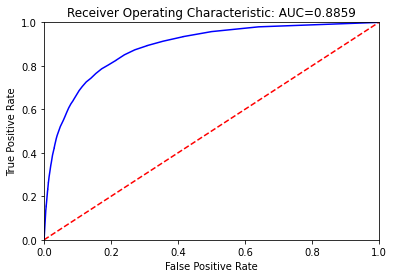

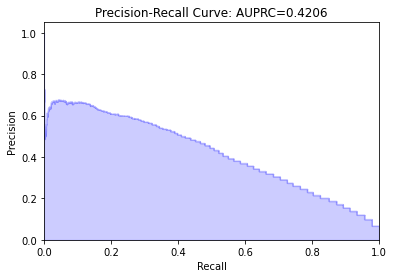

[0.10075249 0.01456604 0.00645894 0.01017829 0.01915777 0.00622097
 0.00994348 0.01668694 0.00312966 0.00602506 0.01181146 0.07761816
 0.09713264 0.05533859 0.06319056 0.093431   0.08550954 0.04739587
 0.07913985 0.00559041 0.00605227 0.00371621 0.00144021 0.00207076
 0.00233687 0.00268833 0.00451857 0.00318185 0.00283799 0.00507757
 0.00557298 0.0049606  0.00511496 0.00275966 0.00704177 0.00273807
 0.00265913 0.00459219 0.0072922  0.00466386 0.00234683 0.00506025
 0.00539261 0.00276466 0.00376131 0.00107722 0.00679043 0.0046707
 0.0043834  0.00477968 0.00875385 0.00590701 0.00543522 0.00171184
 0.00520895 0.0054344  0.0045148  0.00698196 0.00220922 0.00430328
 0.00478017 0.0036637  0.00261075 0.00686402]


In [53]:
print("RandomForest:")
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(random_state=random_seed)
start = time.time()
rf.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = rf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, random_seed=random_seed)
importances = rf.feature_importances_
print(importances)

results = ["RF"]
results.extend(result)
results.append(runtime)
result_list.append(results)

GradientBoosting:
Training time: 60.80716395378113 seconds
AUC: 0.8936033395593963
AUPRC: 0.43720159988541024
Sensitivity: 0.8242240215924427
Specificity: 0.8042275026242962
Score thresold: 0.07080459175735267
2.5 97.5


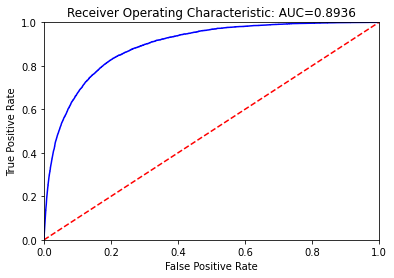

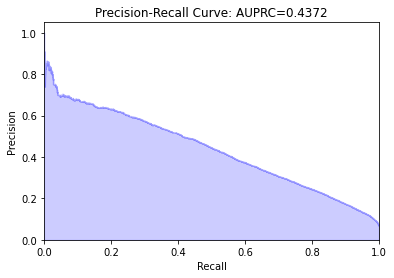

In [54]:
print("GradientBoosting:")
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_train, y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test,random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)

In [55]:
# Temporal skip
'''
print("Support Vector Machine:")
from sklearn.svm import SVC
svc=SVC()
start = time.time()
svc.fit(X_train,y_train)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = svc.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)

results = ["SVM"]
results.extend(result)
results.append(runtime)
result_list.append(results)
'''

'\nprint("Support Vector Machine:")\nfrom sklearn.svm import SVC\nsvc=SVC()\nstart = time.time()\nsvc.fit(X_train,y_train)\nruntime = time.time()-start\nprint(\'Training time:\', runtime, \'seconds\')\nprobs = svc.predict_proba(X_test)\nresult = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval)\n\nresults = ["SVM"]\nresults.extend(result)\nresults.append(runtime)\nresult_list.append(results)\n'

In [56]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


ESI
AUC: 0.789784020478139
AUPRC: 0.1944936375006208
Sensitivity: 0.8959176788124157
Specificity: 0.6333142475427045
Score thresold: -2.6248987751080204
49.525 50.475


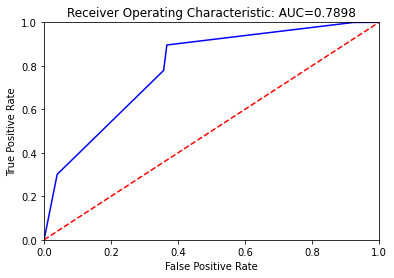

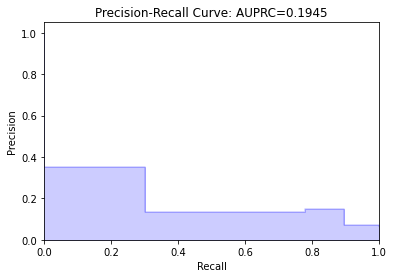

In [57]:
df_test["ESI"] = -df_test["triage_acuity"]
get_score_performance("ESI", random_seed=random_seed)

score_NEWS
AUC: 0.6002591746052351
AUPRC: 0.1525796637565012
Sensitivity: 0.4144736842105263
Specificity: 0.7993129115373605
Score thresold: 2
49.525 50.475


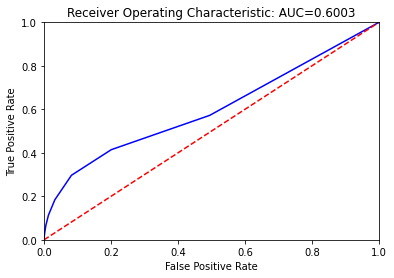

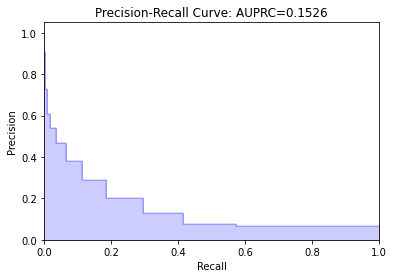

In [58]:
get_score_performance("score_NEWS", random_seed=random_seed)

score_NEWS2
AUC: 0.587080282037631
AUPRC: 0.13968412809478523
Sensitivity: 0.37449392712550605
Specificity: 0.8263789483729364
Score thresold: 2
49.525 50.475


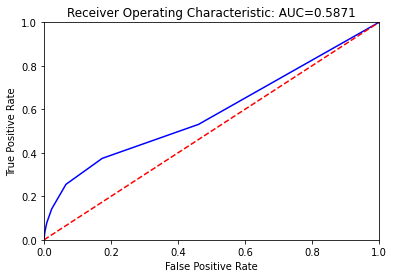

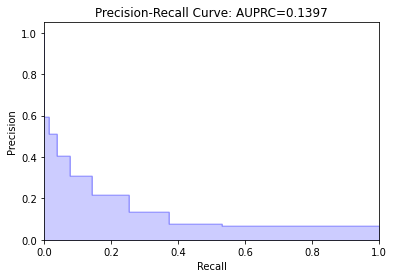

In [59]:
get_score_performance("score_NEWS2", random_seed=random_seed)

score_REMS
AUC: 0.6638998005167845
AUPRC: 0.11202249052255793
Sensitivity: 0.645748987854251
Specificity: 0.6163517511212901
Score thresold: 5
49.525 50.475


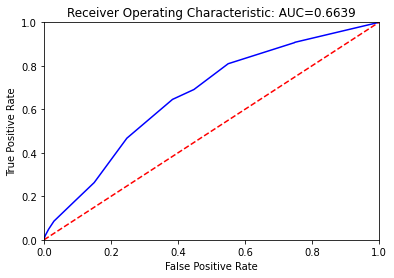

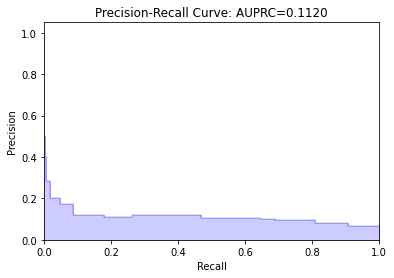

In [60]:
get_score_performance("score_REMS", random_seed=random_seed)

score_MEWS
AUC: 0.6056137210559542
AUPRC: 0.11437508107058239
Sensitivity: 0.40468960863697706
Specificity: 0.7761356045424181
Score thresold: 2
49.525 50.475


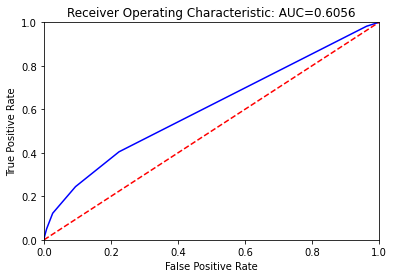

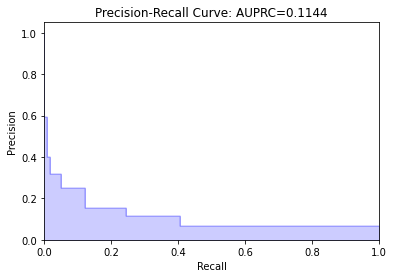

In [61]:
get_score_performance("score_MEWS", random_seed=random_seed)

score_CART
AUC: 0.6923679410907155
AUPRC: 0.15759081132763783
Sensitivity: 0.5588731443994602
Specificity: 0.7325603588128637
Score thresold: 6
49.525 50.475


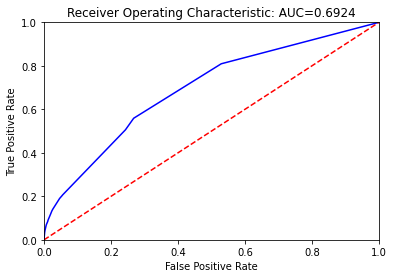

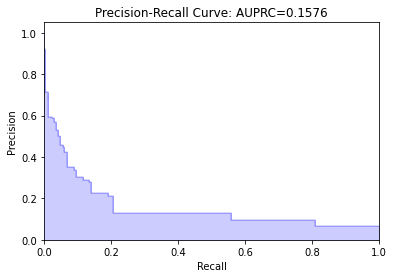

In [62]:
get_score_performance("score_CART", random_seed=random_seed)

In [64]:
import tensorflow as tf
tf.random.set_seed(random_seed)
import tensorflow.keras as keras
from tensorflow.keras import optimizers, metrics, layers, Model
from embedding import *

In [65]:
print("Med2Vec:")
version = 'v10'
batch_size=200
vocabulary = vocabulary_map[version]
df_icd_encode = pd.read_csv(os.path.join(path, 'icd_list_dataset_'+version+'.csv'))
df_train_embed = pd.merge(df_train, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')
df_test_embed = pd.merge(df_test, df_icd_encode[['stay_id', 'icd_encoded_list']], how='left', on='stay_id')

train_gen, test_gen = setup_embedding_data(df_train_embed, df_test_embed, X_train, y_train, X_test, y_test, batch_size)


Model: "embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 icd_input (InputLayer)         [(None, 7930)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 7930, 1024)   8121344     ['icd_input[0][0]']              
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None, 1024)        0           ['embedding_2[0][0]']            
 da)                                                                                              
                                                                                                  
 dense_8 (Dense)                (None, 256)          262400      ['tf.math.reduce_su

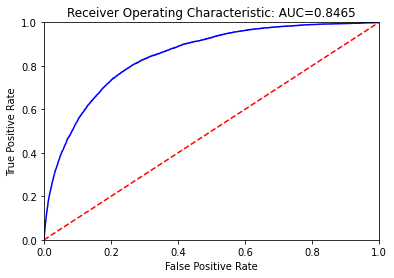

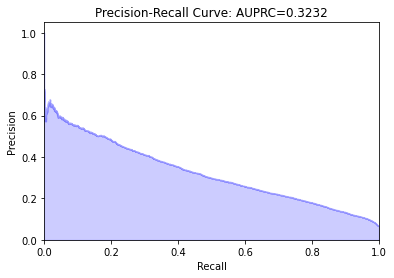

In [66]:
load_model = "embedding_critical_"+version # To train from scratch, set load_model to None
save_model = "embedding_critical_"+version

if load_model:
        model = keras.models.load_model(load_model)
else:
        model = create_embedding_model(vocabulary, len(variable))
model.summary()
model.compile(loss='binary_crossentropy', 
        optimizer=optimizers.Adam(learning_rate=0.001, decay=0.01), 
        metrics=['accuracy', 'AUC', {'aucpr': metrics.AUC(name='aucpr', curve='PR')}, 
                    'TruePositives', 'TrueNegatives', 'Precision', 'Recall'])
runtime = 1063.299
if not load_model:
        start = time.time()
        model.fit(train_gen, epochs=100, class_weight={1:ratio, 0:1}, verbose=0)
        runtime = time.time()-start
        print('Training time:', runtime, 'seconds')
if save_model:
        keras.models.save_model(model, save_model)
output = model.predict(test_gen)
result = PlotROCCurve(output,y_test)

results = ["Med2Vec"]
results.extend(result)
results.append(runtime)
result_list.append(results)

### 4. Performance output

In [67]:
#result_df = pd.read_csv(os.path.join(path, 'result_critical_triage.csv'))
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_critical_triage2.csv'), index=False)
result_df

,Model,auroc,ap,sensitivity,specificity,threshold,lower_auroc,upper_auroc,std_auroc,lower_ap,upper_ap,std_ap,lower_sensitivity,upper_sensitivity,std_sensitivity,lower_specificity,upper_specificity,std_specificity,runtime
0,LR,0.844729,0.318462,0.785931,0.729292,0.058782,0.840187,0.849818,0.002883,0.307136,0.330440,0.006554,0.747942,0.791442,0.014175,0.727430,0.760255,0.010529,5.176900
1,MLP,0.889877,0.412522,0.814440,0.802987,0.072492,0.887482,0.892764,0.001612,0.398430,0.422735,0.006642,0.806200,0.843756,0.010987,0.778383,0.810533,0.009940,403.016052
2,RF,0.885886,0.420576,0.803475,0.808737,0.082705,0.881887,0.888956,0.001949,0.404384,0.433485,0.008784,0.782906,0.810805,0.008586,0.806939,0.829336,0.009431,53.168415
3,GB,0.893603,0.437202,0.824224,0.804228,0.070805,0.890260,0.897093,0.001924,0.424648,0.448428,0.007575,0.806602,0.831896,0.007251,0.795996,0.819905,0.006973,60.807164
4,ESI,0.789784,0.194494,0.895918,0.633314,-2.624899,0.789232,0.789248,0.002706,0.194434,0.194585,0.004029,0.896141,0.896317,0.004091,0.632356,0.632428,0.001665,0.000000
5,score_NEWS,0.600259,0.152580,0.414474,0.799313,2.000000,0.599051,0.599156,0.002283,0.152129,0.152183,0.003333,0.412345,0.412513,0.004119,0.799440,0.799460,0.001326,0.000000
6,score_NEWS2,0.587080,0.139684,0.374494,0.826379,2.000000,0.585591,0.585771,0.002974,0.139651,0.139742,0.003338,0.372398,0.372461,0.004197,0.826578,0.826582,0.001323,0.000000
7,score_REMS,0.663900,0.112022,0.645749,0.616352,5.000000,0.662390,0.662519,0.003482,0.112859,0.112946,0.002607,0.644442,0.644851,0.006023,0.616425,0.616451,0.001541,0.000000
8,score_MEWS,0.605614,0.114375,0.404690,0.776136,2.000000,0.604395,0.604611,0.002371,0.114396,0.114457,0.002743,0.403578,0.403605,0.004640,0.775850,0.775871,0.001620,0.000000
9,score_CART,0.692368,0.157591,0.558873,0.732560,6.000000,0.692052,0.692100,0.003092,0.159520,0.159561,0.003192,0.558894,0.559435,0.006386,0.732834,0.732838,0.001182,0.000000


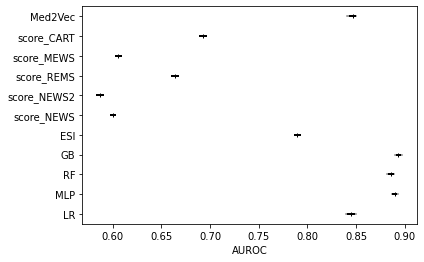

In [68]:
from helpers import plot_confidence_interval
plot_confidence_interval(result_df, metric='auroc', ci=confidence_interval, name = "AUROC", 
                         my_file = 'AUROC_critical.eps', my_path = output_path) 

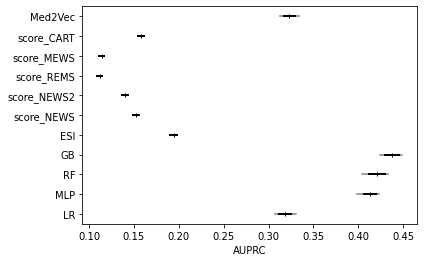

In [69]:
plot_confidence_interval(result_df, metric='ap', ci=confidence_interval, name = "AUPRC", 
                         my_file = 'AUPRC_critical.eps', my_path = output_path)

In [70]:
importance_df = pd.DataFrame(zip(variable, importances), columns=['Variable','Importance'])
importance_df.to_csv(os.path.join(path, 'importances_critical_triage.csv'))
importance_df.sort_values(by='Importance', axis=0,ascending=False)

,Variable,Importance
0,age,0.100752
12,triage_heartrate,0.097133
15,triage_sbp,0.093431
16,triage_dbp,0.085510
18,triage_acuity,0.079140
11,triage_temperature,0.077618
14,triage_o2sat,0.063191
13,triage_resprate,0.055339
17,triage_pain,0.047396
4,n_ed_365d,0.019158
